In [7]:
# Import Libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from zipfile import ZipFile
from urllib.request import urlretrieve
import math

%matplotlib inline


In [2]:
def download_and_unzip(url, save_path):
    print(f"Downloading and extracting assests....", end="")

    # Downloading zip file using urllib package.
    urlretrieve(url, save_path)

    try:
        # Extracting zip file using the zipfile package.
        with ZipFile(save_path) as z:
            # Extract ZIP file contents in the same directory.
            z.extractall(os.path.split(save_path)[0])

        print("Done")

    except Exception as e:
        print("\nInvalid file.", e)

In [3]:
URL = r"https://www.dropbox.com/s/qa1hsyxt66pvj02/opencv_bootcamp_assets_NB10.zip?dl=1"

asset_zip_path = os.path.join(os.getcwd(), f"opencv_bootcamp_assets_NB10.zip")

# Download if assest ZIP does not exists. 
if not os.path.exists(asset_zip_path):
    download_and_unzip(URL, asset_zip_path)   

Basic Idea
The dynamic range of images is limited to 8-bits (0 - 255) per channel
Very bright pixels saturate to 255
Very dark pixels clip to 0
Step 1: Capture Multiple Exposures

In [4]:
#cameras do not have enough resolution to detect all details
#iphone takes 3 subsampled images and combine them to get a high resolution image
def readImagesandTimes():
    #List of exposure times
    filenames = ["img_0.033.jpg", "img_0.25.jpg", "img_2.5.jpg", "img_15.jpg"]
    
    #list of times
    times = np.array([ 1/30.0, 0.25, 2.5, 15.0 ], dtype=np.float32)
    
    #Read the images
    images =[]
    for filename in filenames:
        im = cv2.imread(filename)
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        images.append(im)
    
    return images, times

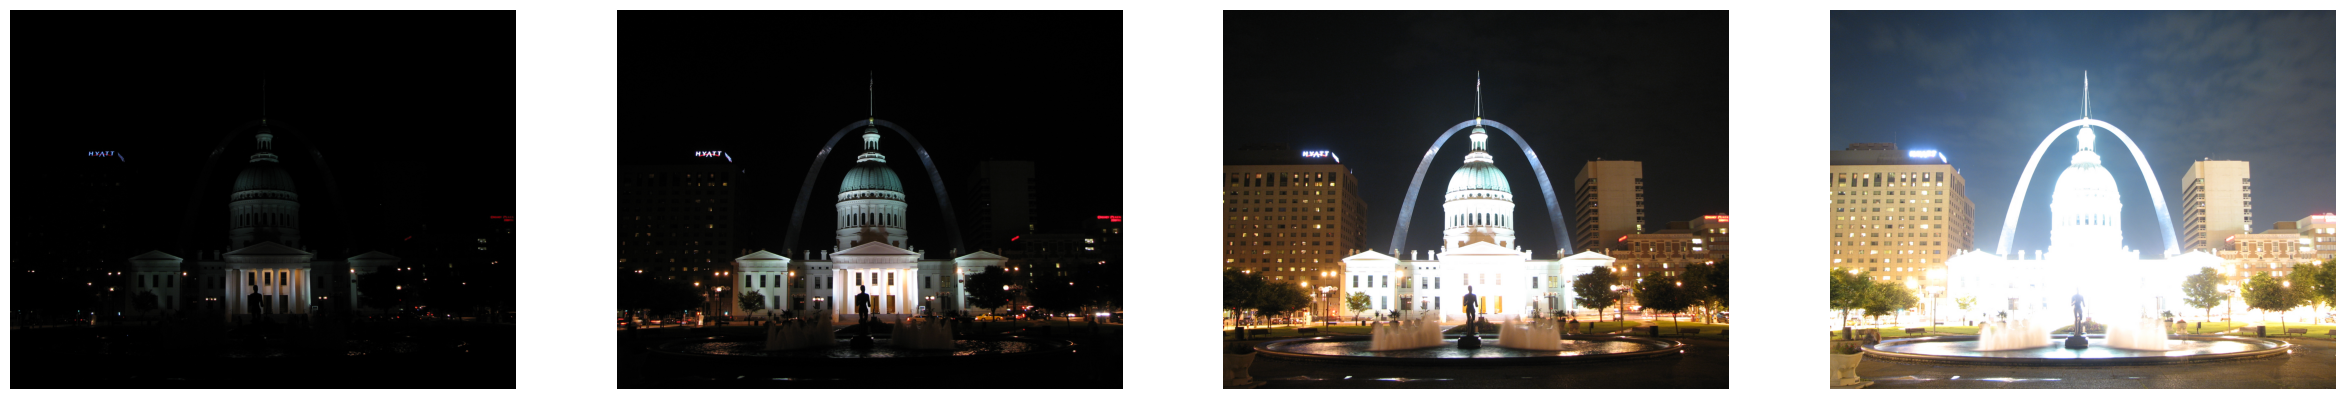

In [9]:
#Images must be aligned before merging
#special class using bitmap to align images
#read images and times
images, times = readImagesandTimes()
num_images = len(images)

plt.figure(figsize=(30, 10))
num_cols = 4
num_rows = math.ceil(num_images/num_cols)
for i in range(num_images):
    plt.subplot(num_rows, num_cols, i+1)
    plt.axis('off')
    plt.imshow(images[i])

#Align images
alignMTB = cv2.createAlignMTB()
alignMTB.process(images,images)
#parameters for process function- src, dst
#Explanation of alignMTB parameters in the documentation https://docs.opencv.org/3.4/d7/db6/classcv_1_1AlignMTB.html

ESTIMATED CAMERA RESPONSE FUNCTION
Since the exposure thing is nonlinear, we need to estimate the camera response function (CRF) to get the actual pixel values

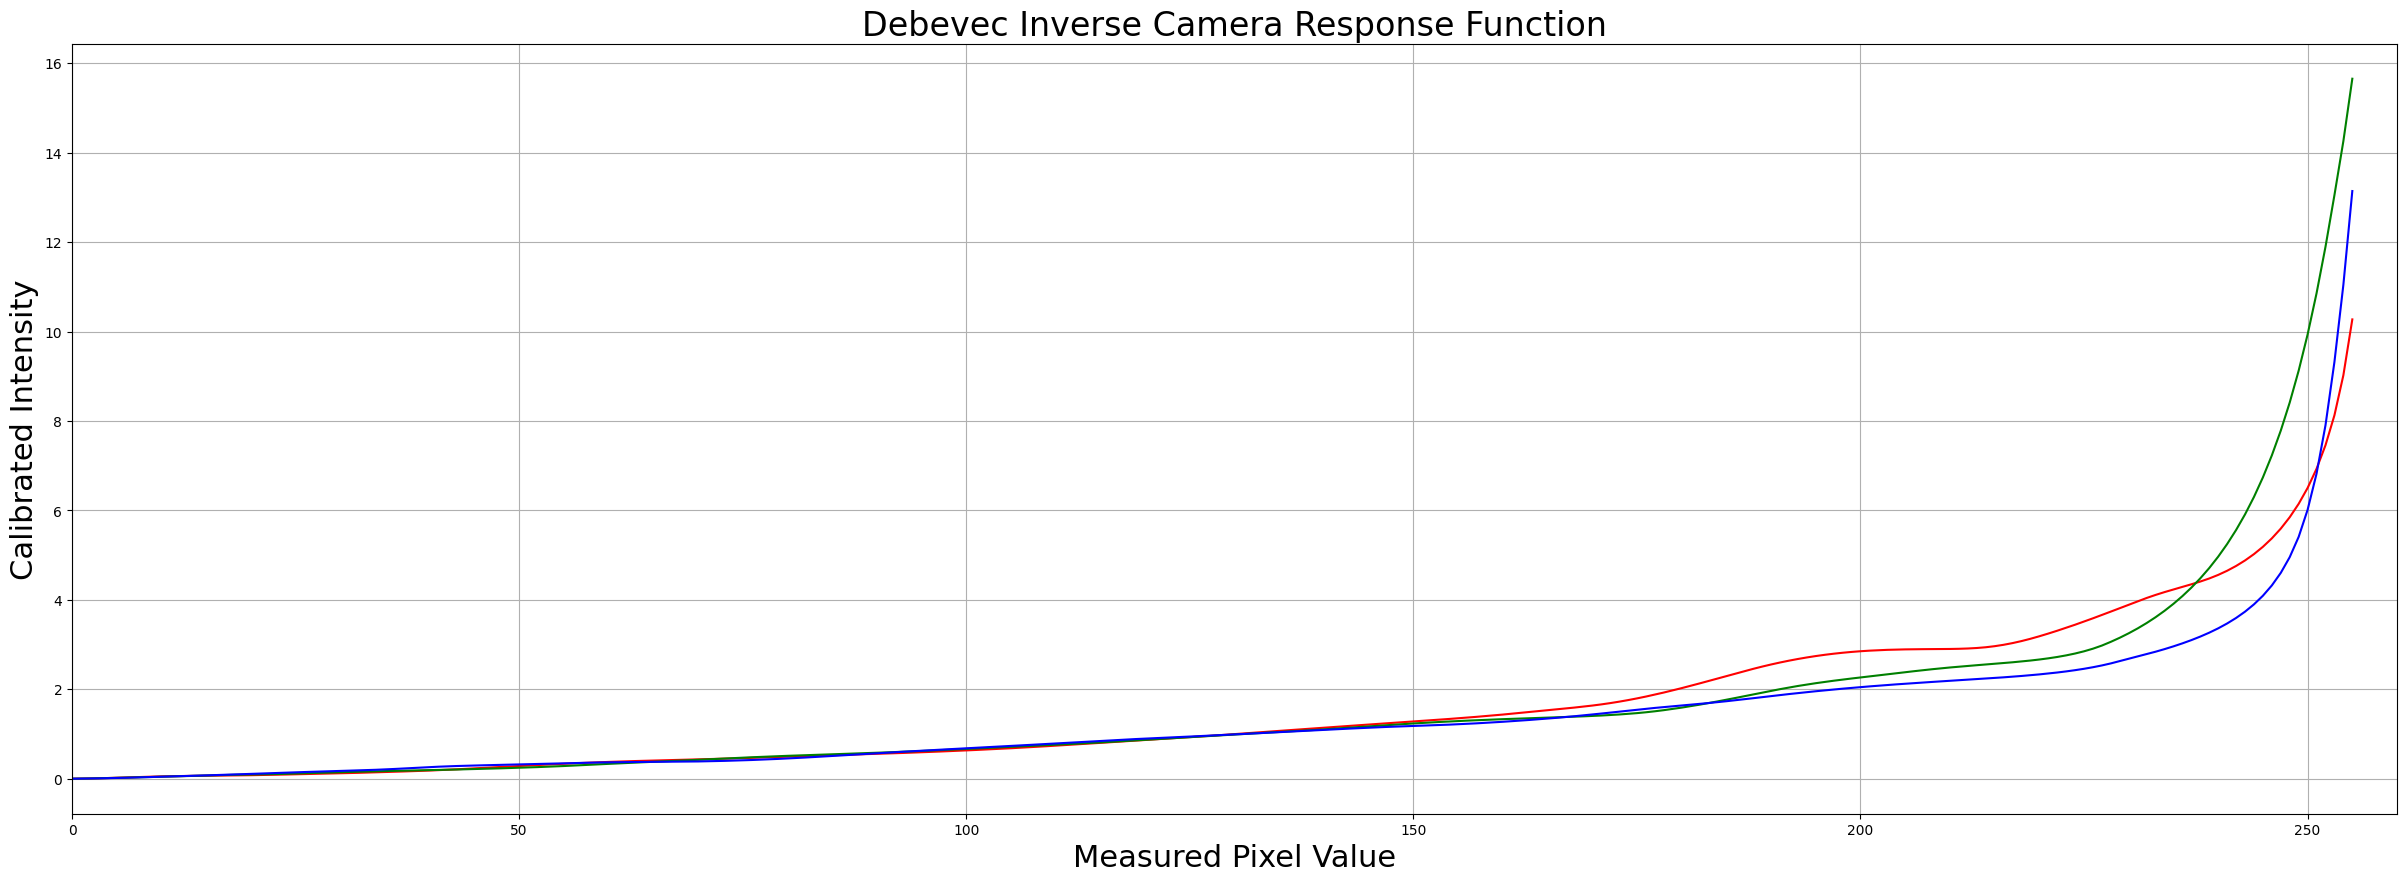

In [6]:
#Find Camera Response Function (CRF)
#This is proprietary to Camera and hence we need to find it by involved optimization, which is easy in OpenCV
calibrateDebevec = cv2.createCalibrateDebevec()
responseDebevec = calibrateDebevec.process(images,times)

#plot the response function
x = np.arange(256, dtype=np.uint8)
y = np.squeeze(responseDebevec)

ax = plt.figure(figsize=(30,10))
plt.title("Debevec Inverse Camera Response Function", fontsize=24)
plt.xlabel("Measured Pixel Value", fontsize=22)
plt.ylabel("Calibrated Intensity", fontsize=22)
plt.xlim([0,260])
plt.grid()
plt.plot(x,y[:,0], 'r', x,y[:,1], 'g', x,y[:,2], 'b')

MERGE EXPOSURE INTO HDR IMAGES

In [11]:
#Merge images into an HDR linear image
mergeDebevec = cv2.createMergeDebevec()
hdrDebevec = mergeDebevec.process(images,times,responseDebevec)

#explanation of parameters in the documentation https://docs.opencv.org/3.4/df/d62/classcv_1_1MergeDebevec.html

#FIltered out low and high pixels since they do not have significant information
#Need to cap the valuus of the pixels to 0 and 255 since this operation can take it to infinity


TONE MAPPING TO DISPLAYABLE RANGE
Using Durand

ldr-Drago.jpg saved


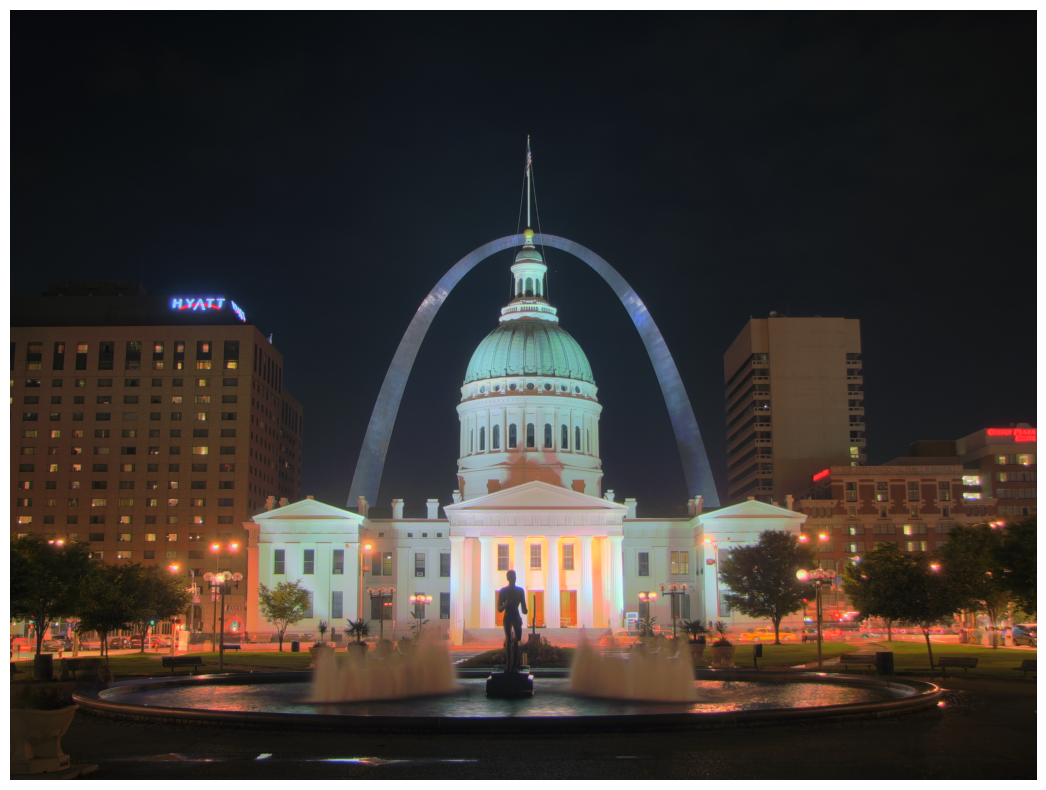

In [28]:
#Tonemap using Drago's method to obtain 24-bit color image
tonemapDrago = cv2.createTonemapDrago(1.0, 0.7)
#parameters for createTonemapDrago function- gamma, saturation
#explanation of parameters in the documentation https://docs.opencv.org/3.4/d6/da7/classcv_1_1TonemapDrago.html

ldrDrago = tonemapDrago.process(hdrDebevec)
ldrDrago = 3 * ldrDrago #increase brightness 3 times

plt.figure(figsize=(20,10)); plt.imshow(np.clip(ldrDrago,0,1)); plt.axis('off')
ldrDrago_bgr = cv2.cvtColor(ldrDrago, cv2.COLOR_RGB2BGR)

cv2.imwrite('ldr-Drago.jpg',ldrDrago_bgr*255)

print("ldr-Drago.jpg saved")


ldr-Reinhard.jpg saved


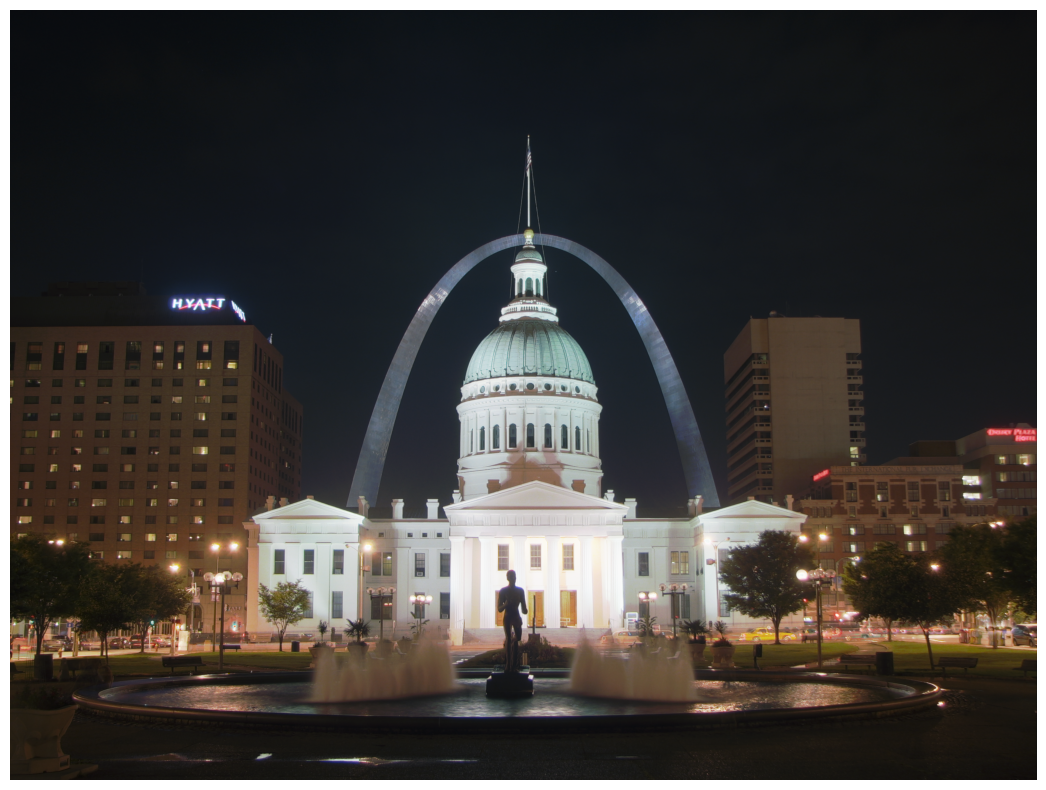

In [34]:
#Tone map using Reinhard's method to obtain 24-bit color image
tonemapReinhard  = cv2.createTonemapReinhard(1.5,0,0,0)
ldrReinhard = tonemapReinhard.process(hdrDebevec)
ldrReinhard = 1.0 * ldrReinhard #increase brightness 1 times
plt.figure(figsize=(20,10)); plt.imshow(np.clip(ldrReinhard,0,1)); plt.axis('off')
ldrReinhard_bgr = cv2.cvtColor(ldrReinhard, cv2.COLOR_RGB2BGR)
cv2.imwrite('ldr-Reinhard.jpg',ldrReinhard_bgr*255)
print("ldr-Reinhard.jpg saved")

ldr-Mantiuk.jpg saved


/home/trec/anaconda3/envs/vision/lib/python3.11/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


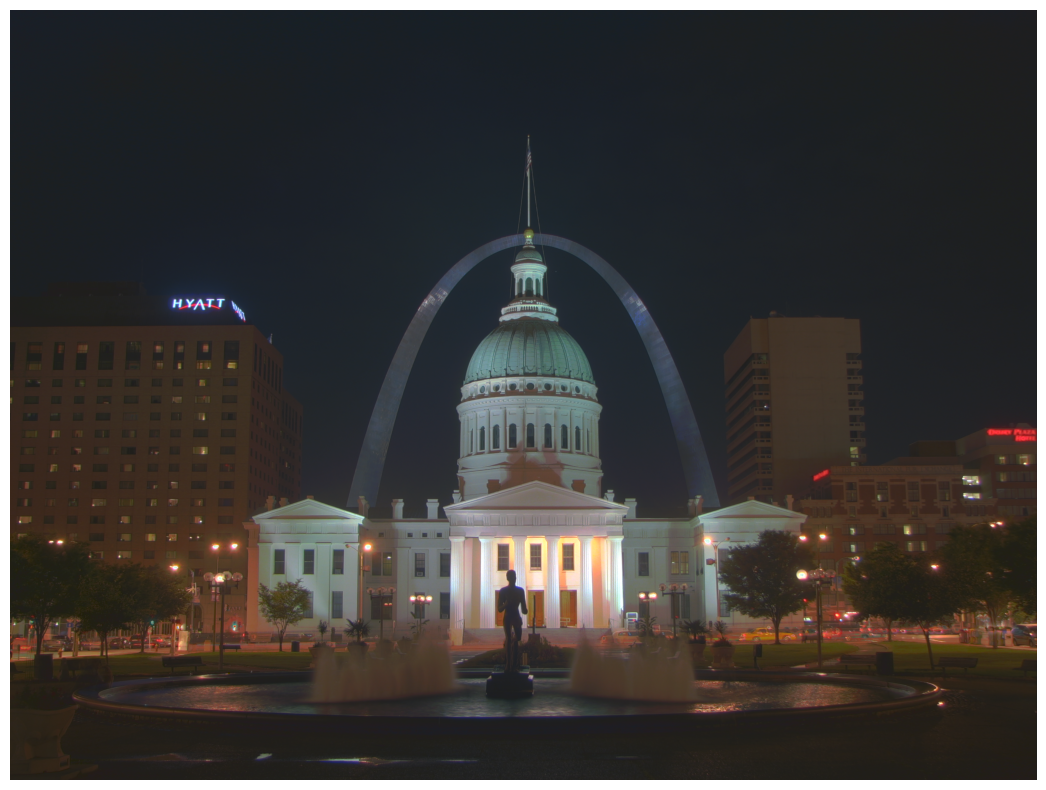

In [21]:
#Tone map using Mantiuk's method to obtain 24-bit color image
tonemapMantiuk = cv2.createTonemapMantiuk(2.2,0.85, 1.2)
ldrMantiuk = tonemapMantiuk.process(hdrDebevec)
ldrMantiuk = 3*ldrMantiuk #increase brightness 3 times
plt.figure(figsize=(20,10)); plt.imshow(np.clip(ldrMantiuk,0,1)); plt.axis('off')
ldrMantiuk_bgr = cv2.cvtColor(ldrMantiuk, cv2.COLOR_RGB2BGR)
cv2.imwrite('ldr-Mantiuk.jpg',ldrMantiuk_bgr*255)
print("ldr-Mantiuk.jpg saved")